# The ZnFlow Package

Define Node connections using a directional multigraph.
Nodes are connected through Node attributes.
A Node can have multiple connections to another Node through different Attributes.
Each Node is definied by a unique `_id_` which could be automatically generated based on the state of the Node.

In [1]:
import znflow

A Node is inherited from `znflow.Node` and can have many different `znflow.EdgeAttribute` that will connect the Nodes to  other Nodes or behave as inputs / outputs from the Node.
In general a `Node` is very similar to a dataclass and even implements a `_post_init_` method.
We equip our `Node` with a `run` method that computes the `outputs` based on the `inputs`.

In [2]:
class Node(znflow.Node):
    inputs = znflow.EdgeAttribute()
    outputs = znflow.EdgeAttribute(None)
    
    def run(self):
        self.outputs = self.inputs * 2

In [3]:
node1 = Node(inputs=25)
node1.run()
node1

Node(inputs=25, outputs=50)

We can now create multiple Nodes and connect them. Nodes are connected through `znflow.GraphManager` as follows.
Every Node inside the contextmanager will automatically be stored inside the `dag` object.

In [4]:
with znflow.DiGraph() as graph:
    node1 = Node(inputs=25)
    node2 = Node(inputs=node1.outputs) # TODO Node(inputs=node1)

If we look at the new Node, we see that `Node.inputs` is now a `NodeConnector` to the connected Node.

In [5]:
node1

Node(inputs=25, outputs=None)

In [6]:
node2

Node(inputs=NodeConnector(attribute='outputs', graph=<DiGraph with 2 nodes and 1 edges>, node=Node(inputs=25, outputs=None)), outputs=None)

Using `networkx` we can visualize the connection.

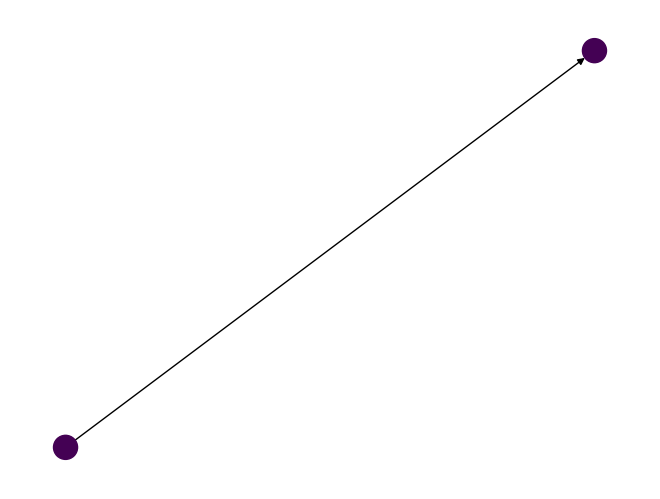

In [7]:
znflow.draw(graph)

Another way of connecting Nodes is through `znflow.DiGraph().write_graph`.
It is important to mention, that we can not use `node1.outputs` here, because we know `node1.outputs is None`. Therefore, we have to replace it by `node1 @ "outputs"`

In [8]:
node1 = Node(inputs=25)
node2 = Node(inputs=node1 @ "outputs")
print(f"{node1.outputs = }")
print(f'{node1 @ "outputs" = }')
print(f"{node2 = }")

node1.outputs = None
node1 @ "outputs" = NodeConnector(attribute='outputs', graph=<None>, node=Node(inputs=25, outputs=None))
node2 = Node(inputs=NodeConnector(attribute='outputs', graph=<None>, node=Node(inputs=25, outputs=None)), outputs=None)


In [9]:
graph = znflow.DiGraph()
graph.write_graph(node1, node2)

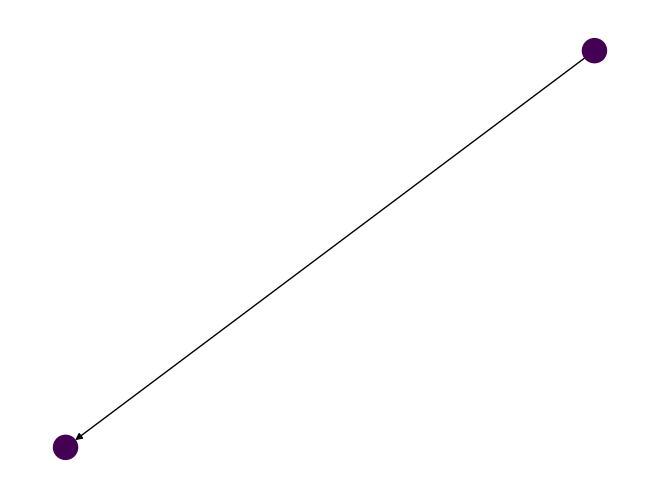

In [10]:
znflow.draw(graph)

# Run the Graph

First let's build some more interesting graphs:

In [11]:
class SumNodes(znflow.Node):
    inputs = znflow.EdgeAttribute()
    outputs = znflow.EdgeAttribute(None)
    
    def _post_init_(self):
        self._id_ = self.__repr__()

    def run(self):
        self.outputs = sum(self.inputs)

In [12]:
with znflow.DiGraph() as graph:
    node1 = Node(inputs=5)
    node2 = Node(inputs=10)
    node3 = Node(inputs=node1.outputs)
    node4 = Node(inputs=node2.outputs)
    node5 = SumNodes(inputs=[node3.outputs, node4.outputs])
    node6 = SumNodes(inputs=[node2.outputs, node5.outputs])
    node7 = SumNodes(inputs=[node6.outputs])

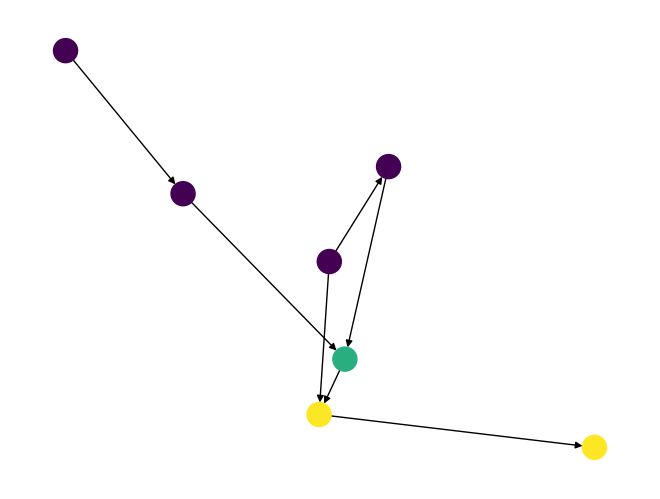

In [13]:
znflow.draw(graph)

In [14]:
graph.run() # default is to call node.run()
graph.nodes

NodeView((Node(inputs=5, outputs=10), Node(inputs=10, outputs=20), Node(inputs=10, outputs=20), Node(inputs=20, outputs=40), SumNodes(inputs=[20, 40], outputs=60), SumNodes(inputs=[20, 60], outputs=80), SumNodes(inputs=[80], outputs=80)))

Or even more nested

In [15]:
import random
k = 3
j = 3
i = 3

with znflow.DiGraph() as graph:
    kdx_nodes = []
    for kdx in range(k):
        jdx_nodes = []
        for jdx in range(j):
            idx_nodes = []
            for idx in range(i):
                idx_nodes.append(Node(inputs=random.random()))
            jdx_nodes.append(SumNodes(inputs=[x.outputs for x in idx_nodes]))
        kdx_nodes.append(SumNodes(inputs=[x.outputs for x in jdx_nodes]))
            
    end_node = SumNodes(inputs=[x.outputs for x in kdx_nodes])

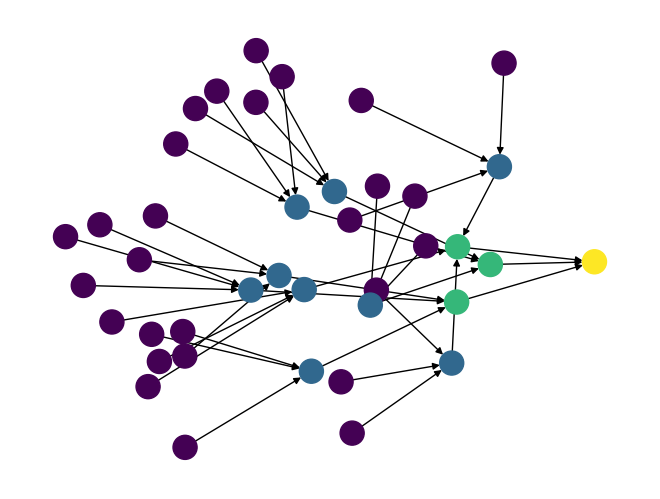

In [16]:
# nx.draw(dag)
znflow.draw(graph)

In [17]:
%time graph.run() # default is to call node.run()
# # [x._id_ for x in dag.nodes]
[x for x in graph.nodes]

CPU times: user 17.2 ms, sys: 4.9 ms, total: 22.1 ms
Wall time: 21.6 ms


[Node(inputs=0.9227526433950187, outputs=1.8455052867900374),
 Node(inputs=0.6731406649434623, outputs=1.3462813298869245),
 Node(inputs=0.03981013864032046, outputs=0.07962027728064092),
 SumNodes(inputs=[1.8455052867900374, 1.3462813298869245, 0.07962027728064092], outputs=3.271406893957603),
 Node(inputs=0.05962093423194126, outputs=0.11924186846388252),
 Node(inputs=0.47496137714834086, outputs=0.9499227542966817),
 Node(inputs=0.6026827741329177, outputs=1.2053655482658354),
 SumNodes(inputs=[0.11924186846388252, 0.9499227542966817, 1.2053655482658354], outputs=2.2745301710263996),
 Node(inputs=0.5698720577945242, outputs=1.1397441155890484),
 Node(inputs=0.6576144531235205, outputs=1.315228906247041),
 Node(inputs=0.23459314890193417, outputs=0.46918629780386834),
 SumNodes(inputs=[1.1397441155890484, 1.315228906247041, 0.46918629780386834], outputs=2.9241593196399576),
 SumNodes(inputs=[3.271406893957603, 2.2745301710263996, 2.9241593196399576], outputs=8.470096384623961),
 Node